# 1.0 Estudo de caso: construindo uma rede de páginas da Wikipédia

> Adicionar aspas

## 1.1 Introdução

Até agora, aprendemos duas maneiras de construir uma rede complexa:
- a partir de um arquivo CSV
- manualmente

O que é difícil para redes pequenas pode ser impossível para redes de médio a grande porte; pode ser impossível até mesmo para redes pequenas se você precisar repetir a análise muitas
vezes. O estudo de caso nesta lição mostra **como construir uma grande
rede de forma fácil**:
- coletando automaticamente dados de nós e bordas da Internet.

O outro objetivo deste estudo (além de dominar novas técnicas de construção de rede) é bastante pragmático.
- Você não gostaria de saber onde a **análise de rede complexa** se encaixa no contexto de outros assuntos e disciplinas?

Uma resposta para esta pergunta está próxima: [na Wikipedia](https://en.wikipedia.org/wiki/Complex_network).

Vamos começar com a página da Wikipedia sobre redes complexas — a página inicial.
(Infelizmente, não há uma página sobre análise de rede complexa em si.) O corpo da página
tem links externos e links para outras páginas da Wikipédia. Essas outras páginas
presumivelmente estão de alguma forma relacionadas a redes complexas, ou então por que
os editores da Wikipédia as forneceriam?
Para construir uma rede a partir da página semente e outras páginas relevantes, **vamos tratar
as páginas (e os respectivos assuntos da Wikipédia) como os nós da rede e
os links entre as páginas como as arestas da rede**. Você usará a amostragem
de bola de neve (uma busca em largura ou [algoritmo BFS](https://en.wikipedia.org/wiki/Breadth-first_search)) para descobrir todos os nós e arestas de interesse.

<img width="200" src="https://drive.google.com/uc?export=view&id=1iC-cieOaZKy80adviVISLmM-2Zm7NL-i">

Como resultado, você terá uma rede de todas as páginas relacionadas a redes complexas
e, com sorte, você tirará algumas conclusões sobre isso.

## 1.2 Obtenha os dados, construa a rede

A primeira metade do script do projeto consiste em:

1. o prólogo de inicialização
2. um loop pesado que recupera as páginas da Wikipédia e simultaneamente constrói a rede de nós e arestas.

Vamos primeiro importar todos os módulos necessários. Precisaremos de:

- o módulo **wikipedia** para buscar e explorar páginas da Wikipédia
- o operador **itemgetter** para classificar uma lista de tuplas
- e, naturalmente, o próprio **networkx**.

Para direcionar o **processo de bola de neve**, defina a constante **SEED, o nome da
página inicial**.

> Como uma observação lateral, ao alterar o nome da página inicial, você pode
aplicar esta análise a qualquer outro assunto na Wikipédia.

Por último, mas não menos importante, quando você começar a bola de neve, você eventualmente (e
muito em breve) esbarrará nas páginas que descrevem os números ISBN e ISSN, o
arXiv, PubMed e similares. Quase todas as outras páginas da Wikipédia se referem a uma ou
mais dessas páginas. Essa hiperconectividade transforma qualquer rede em
uma coleção de estrelas gigantes quase perfeitas, fazendo com que todas as redes baseadas na Wikipédia
pareçam semelhantes. **Para evitar a síndrome do estrelato**, trate as páginas “estrelas”
conhecidas como stop words na recuperação de informações — em outras palavras, ignore quaisquer links
para elas.

Construir a **lista negra de stop words**, STOPS, é uma questão de tentativa
e erro. Colocamos treze assuntos nela; você pode querer adicionar mais quando
encontrar outras “estrelas”. Também excluímos páginas cujos nomes começam com
**"Lista de"**, porque são simplesmente listas de outros assuntos.

In [20]:
!pip install wikipedia

In [21]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

In [22]:
nx.__version__

'3.3'

In [38]:
#https://en.wikipedia.org/wiki/Complex_network
SEED1 = "São José do Campestre".title()
SEED2 = "Medium (site)".title()
SEED3 = "Santana do Seridó".title()
STOPS = (
    "Network Theory",
    "Graph Theory",
    "Scale-Free Network",
    "Small-World Network",
    "Erdős–Rényi Model",
    "Barabási–Albert Model",
    "Social Network",
    "Biological Network",
    "Ecological Network",
    "Neural Network",
    "Computer Network",
    "Internet",
    "World Wide Web",
    "Power Grid",
    "Transportation Network",
    "Economic Network",
    "Social Network Analysis",
    "Complex System",
    "Chaos Theory"
)


O próximo fragmento de código lida com a configuração do **processo de bola de neve**. Uma
busca em largura, ou BFS (às vezes conhecida por programadores de computador
como um algoritmo de bola de neve), deve lembrar quais **páginas já foram
processadas** e quais foram **descobertas, mas ainda não processadas**.
- as primeiras são armazenadas no conjunto **done_set**;
- as últimas, na lista **todo_lst** e **todo_set**.

Você precisa de duas estruturas de dados para as páginas não processadas porque você quer
saber se uma página já foi registrada (uma pesquisa não ordenada, *todo_set*) e
qual página é a próxima a ser processada (uma pesquisa ordenada, *todo_lst*).

Acumular uma rede extensa — e a Wikipedia com 6.578.766 artigos
somente no segmento em inglês pode produzir uma rede enorme! — leva um
tempo considerável.

<img width="300" src="https://drive.google.com/uc?export=view&id=1mzwKkNsLhTmOxWailBsFUOba_YqYpyes">

Suponha que você comece com um nó semente, e digamos que ele tenha $N\approx 100$ vizinhos.
Cada um deles tem $N$ vizinhos também, para o total de $\approx N+N×N$ nós. A
terceira rodada de descoberta adiciona $\approx N×N×N$ mais nós. O tempo para raspar cada
próxima camada de nós cresce exponencialmente. Para este exercício, vamos processar apenas
o próprio nó semente e seus vizinhos imediatos (camadas 0 e 1). O processamento
da camada 2 ainda é viável, mas a camada 3 requer $N×N×N×N\approx 10^8$ downloads de páginas. Para monitorar a distância do nó atualmente processado até a semente, armazene a camada à qual o nó pertence e o nome do nó juntos como uma tupla na lista **todo_lst**.

In [39]:
def start(SEED):
  todo_lst = [(0, SEED)] # The SEED is in the layer 0
  todo_set = set(SEED) # The SEED itself
  done_set = set() # Nothing is done yet
  return todo_lst, todo_set, done_set
todo_lst1, todo_set1, done_set1 = start(SEED1)
todo_lst2, todo_set2, done_set2 = start(SEED2)
todo_lst3, todo_set3, done_set3 = start(SEED3)

**A saída do exercício é um gráfico NetworkX**. O próximo fragmento criará
um gráfico direcionado vazio que mais tarde absorverá nós e arestas descobertos.

> Escolhemos um **gráfico direcionado** porque as arestas que representam links HTML
são naturalmente direcionadas: um link da página A para a página B não implica um link recíproco.

O mesmo fragmento prepara o algoritmo extraindo o primeiro item “a fazer”
(tanto sua camada quanto o nome da página) da lista homônima.

In [40]:
g1 = nx.DiGraph()
layer1, page1 = todo_lst1[0]

g2 = nx.DiGraph()
layer2, page2 = todo_lst2[0]

g3 = nx.DiGraph()
layer3, page3 = todo_lst3[0]

Pode levar uma fração de segundo para executar as cinco primeiras linhas do script.
Pode levar o ano inteiro ou mais para terminar as próximas vinte linhas
porque elas contêm o loop principal de coleta/construção do projeto.

In [42]:
%%time
def start(g, todo_lst, todo_set, done_set, layer, page):
  while layer < 2:
    # Remove the name page of the current page from the todo_lst,
    # and add it to the set of processed pages.
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)

    # Show progress
    print(layer, page)

    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print("Could not load", page)
      layer, page = todo_lst[0]
      continue

    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]
  return g
g1 = start(g1, todo_lst1, todo_set1, done_set1, layer1, page1)
g2 = start(g2, todo_lst2, todo_set2, done_set2, layer2, page2)
g3 = start(g3, todo_lst3, todo_set3, done_set3, layer3, page3)

0 São José Do Campestre
1 Afonso Bezerra
1 Alexandria, Rio Grande Do Norte
1 Almino Afonso
1 Alto Do Rodrigues
1 Angicos
1 Antônio Martins
1 Apodi, Rio Grande Do Norte
1 Areia Branca, Rio Grande Do Norte
1 Arês, Rio Grande Do Norte
1 Assu, Rio Grande Do Norte
1 Baraúna, Rio Grande Do Norte
1 Barcelona, Rio Grande Do Norte
1 Baía Formosa
1 Bento Fernandes
1 Boa Saúde
1 Bodó
1 Bom Jesus, Rio Grande Do Norte
1 Brazil
1 Brejinho, Rio Grande Do Norte
1 Caicó
1 Caiçara Do Norte
1 Caiçara Do Rio Do Vento
1 Campo Grande, Rio Grande Do Norte
1 Campo Redondo, Rio Grande Do Norte
1 Canguaretama
1 Caraúbas, Rio Grande Do Norte
1 Carnaubais
1 Carnaúba Dos Dantas
1 Ceará-Mirim
1 Cerro Corá, Rio Grande Do Norte
1 Coronel Ezequiel
1 Coronel João Pessoa


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Coronel João Pessoa
1 Cruzeta
1 Currais Novos
1 Doutor Severiano
1 Encanto, Rio Grande Do Norte
1 Equador, Rio Grande Do Norte
1 Espírito Santo, Rio Grande Do Norte
1 Extremoz
1 Felipe Guerra
1 Fernando Pedroza, Rio Grande Do Norte
1 Florânia
1 Francisco Dantas
1 Frutuoso Gomes
1 Galinhos
1 Goianinha
1 Governador Dix-Sept Rosado
1 Grossos
1 Guamaré
1 Ielmo Marinho
1 Ipanguaçu
1 Ipueira
1 Itajá, Rio Grande Do Norte
1 Itaú, Rio Grande Do Norte
1 Jandaíra, Rio Grande Do Norte
1 Janduís
1 Japi
1 Jardim De Angicos
1 Jardim De Piranhas
1 Jardim Do Seridó
1 Jaçanã, Rio Grande Do Norte
1 José Da Penha
1 João Câmara, Rio Grande Do Norte
1 João Dias
1 Jucurutu
1 Jundiá, Rio Grande Do Norte
1 Lagoa Nova
1 Lagoa Salgada
Could not load Lagoa Salgada
1 Lagoa D'Anta
1 Lagoa De Pedras
1 Lagoa De Velhos
1 Lajes, Rio Grande Do Norte
1 Lajes Pintadas
1 Lucrécia
1 Luís Gomes
1 Macau, Rio Grande Do Norte
1 Macaíba
1 Major Sales
Could not load Major Sales
1 Marcelino Vieira
1 Martins, Rio Gra

In [43]:
print("SJC {} nodes, {} edges".format(len(g1), nx.number_of_edges(g1)))
print("Medium {} nodes, {} edges".format(len(g2), nx.number_of_edges(g2)))
print("Santana {} nodes, {} edges".format(len(g3), nx.number_of_edges(g3)))

SJC 5629 nodes, 17359 edges
Medium 19471 nodes, 25403 edges
Santana 2758 nodes, 4034 edges


A rede de interesse está agora na variável g. Mas ela é “suja”: imprecisa, incompleta e errônea.

## 1.3 Elimine Duplicatas

Muitas páginas da Wikipédia existem sob dois ou mais nomes. Por exemplo, há
páginas sobre **Rede Complexa** e **Redes Complexas**. A última redireciona
para a primeira, mas a NetworkX não sabe sobre o redirecionamento.

Mesclar com precisão todos os nós duplicados envolve ferramentas de **processamento de linguagem natural
(PLN) que estão fora do escopo deste curso**. Pode ser suficiente juntar
apenas os nós que diferem pela presença/ausência da letra s no final
ou um hífen no meio.

Comece a remover autoloops (páginas que se referem a si mesmas). Os loops não alteram
as propriedades da rede, mas afetam a correção da eliminação de nós duplicados.
Agora, você precisa de uma lista de pelo menos alguns nós duplicados. Você pode construí-la
olhando para cada nó em g e verificando se um nó com o mesmo nome, mas
com um s no final, também está em g.

Passe cada par de nomes de nós duplicados para a função **nx.contracted_nodes(g,u,v)** que mescla o nó v no nó u no gráfico g. A função reatribui todas as arestas anteriormente incidentes a v, para u. Se você não passar a opção **self_loops=False**, a função converte uma aresta de v para u (se houver) para um self-loop.

In [44]:
# make a copy of raw graph
original1 = g1.copy()
original2 = g2.copy()
original3 = g3.copy()


In [45]:
# remove self loops
g1.remove_edges_from(nx.selfloop_edges(g1))
g2.remove_edges_from(nx.selfloop_edges(g2))
g3.remove_edges_from(nx.selfloop_edges(g3))

# identify duplicates like that: 'network' and 'networks'
duplicates1 = [(node, node + "s")
              for node in g1 if node + "s" in g1
             ]
duplicates2 = [(node, node + "s")
              for node in g2 if node + "s" in g2
             ]
duplicates3 = [(node, node + "s")
              for node in g3 if node + "s" in g3
             ]

for dup in duplicates1:
  # *dup is a technique named 'unpacking'
  g1 = nx.contracted_nodes(g1, *dup, self_loops=False)
for dup in duplicates2:
  g2 = nx.contracted_nodes(g2, *dup, self_loops=False)
for dup in duplicates3:
  g3 = nx.contracted_nodes(g3, *dup, self_loops=False)

print(f"SJC {duplicates1}")
print(f"Medium {duplicates2}")
print(f"Santana {duplicates3}")


duplicates1 = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g1]
                if x != y and y in g1]
duplicates2 = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g2]
                if x != y and y in g2]
duplicates3 = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g3]
                if x != y and y in g3]



print(duplicates1)
print(duplicates2)
print(duplicates3)

for dup in duplicates1:
  g1 = nx.contracted_nodes(g1, *dup, self_loops=False)
for dup in duplicates2:
  g2 = nx.contracted_nodes(g2, *dup, self_loops=False)
for dup in duplicates3:
  g3 = nx.contracted_nodes(g3, *dup, self_loops=False)







# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
print("SJC")
nx.set_node_attributes(g1, 0,"contraction")
nx.set_edge_attributes(g1, 0,"contraction")


print("Medium")
nx.set_node_attributes(g2, 0,"contraction")
nx.set_edge_attributes(g2, 0,"contraction")

print("Santana")
nx.set_node_attributes(g3, 0,"contraction")
nx.set_edge_attributes(g3, 0,"contraction")

SJC [('Cashew', 'Cashews'), ('Dune', 'Dunes'), ('Mango', 'Mangos'), ('Afro-Brazilian', 'Afro-Brazilians'), ('Asian Brazilian', 'Asian Brazilians'), ('White Brazilian', 'White Brazilians'), ('Bean', 'Beans')]
Medium [('Magazine', 'Magazines'), ('Mobile App', 'Mobile Apps'), ('Patent', 'Patents'), ('Trademark', 'Trademarks'), ('Weather Forecast', 'Weather Forecasts'), ('Artificial Neural Network', 'Artificial Neural Networks'), ('Chatbot', 'Chatbots'), ('Convolutional Neural Network', 'Convolutional Neural Networks'), ('Deepfake', 'Deepfakes'), ('Expert System', 'Expert Systems'), ('Genetic Algorithm', 'Genetic Algorithms'), ('Graphics Processing Unit', 'Graphics Processing Units'), ('Heuristic', 'Heuristics'), ('Neuron', 'Neurons'), ('Self-Driving Car', 'Self-Driving Cars'), ('Support Vector Machine', 'Support Vector Machines'), ('Blood Substitute', 'Blood Substitutes'), ('Erythrocyte', 'Erythrocytes'), ('Thrombocyte', 'Thrombocytes'), ('White Blood Cell', 'White Blood Cells'), ('Meteor

In [46]:
print("{} nodes, {} edges".format(len(g1), nx.number_of_edges(g1)))
print("{} nodes, {} edges".format(len(g2), nx.number_of_edges(g2)))
print("{} nodes, {} edges".format(len(g3), nx.number_of_edges(g3)))


5620 nodes, 17338 edges
19407 nodes, 25356 edges
2753 nodes, 4027 edges


## 1.4 Truncar a rede

Por que você passou por todos esses problemas na Wikipédia? Primeiro, para construir uma
rede de assuntos relacionados a redes complexas — e aqui está. Segundo, para
encontrar outros tópicos significativos relacionados a redes complexas. **Mas qual é a
medida de significância?**

Você descobrirá uma variedade de medidas de rede mais adiante neste curso. Por enquanto, vamos nos concentrar em um **nó indegree** — o número de arestas direcionadas para o nó. (No mesmo espírito, o número de arestas direcionadas para fora do nó é chamado de **outdegree**.) O indegree de um nó é igual ao número de links HTML apontando para a respectiva página. **Se uma página tiver muitos links para ela, o tópico da página deve ser significativo.**

O gráfico extraído
tem 13.526 nós e 24.724 arestas — uma média de 1,82 arestas por nó. **A maioria
dos nós tem apenas uma conexão**. (Curiosamente, não há nós isolados
sem conexão no gráfico. Mesmo que eles existam, você não os encontrará
por causa da forma como o efeito bola de neve funciona.) **Você pode remover todos os nós com
apenas uma aresta incidente para tornar a rede mais compacta e menos cabeluda
sem prejudicar os resultados finais**.

sao jose campestre.graphml


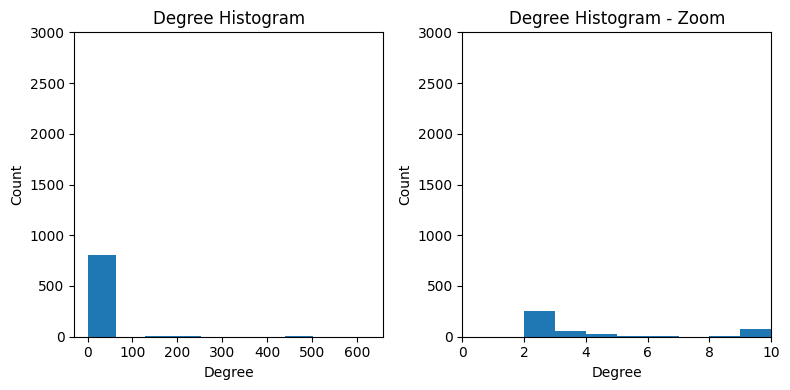



Medium.graphml


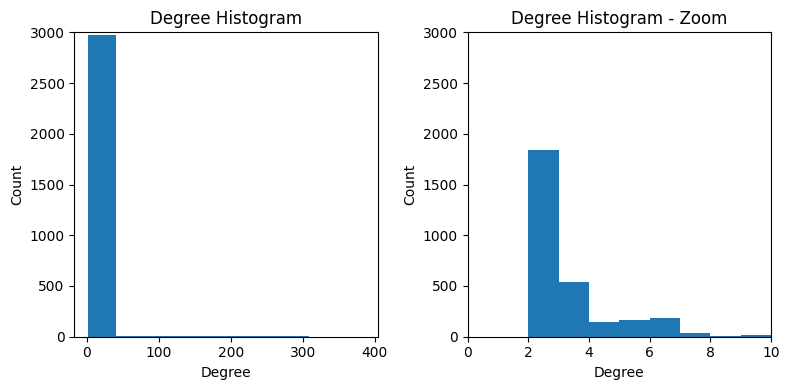



santana do serido.graphml


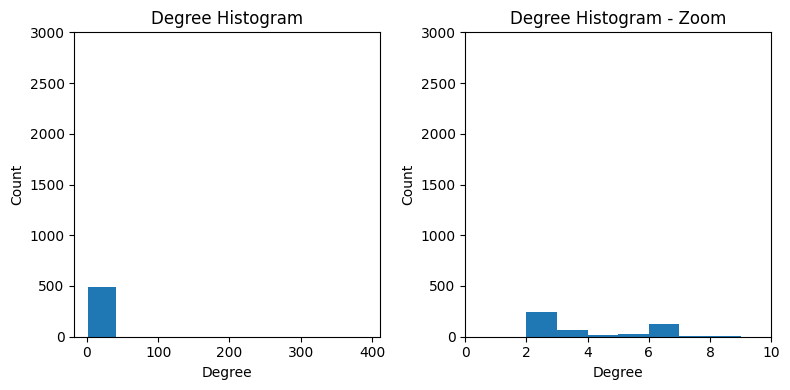

In [54]:

g1 = nx.read_graphml('/content/sao jose campestre.graphml')
g2 = nx.read_graphml('/content/Medium.graphml')
g3 = nx.read_graphml('/content/santana do serido.graphml')

def plote(g):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  ax[0].hist(degree_sequence)
  ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")
  ax[0].set_ylim(0,3000)

  ax[1].set_title("Degree Histogram - Zoom")
  ax[1].set_ylabel("Count")
  ax[1].set_xlabel("Degree")
  ax[1].set_xlim(0,10)
  ax[1].set_ylim(0,3000)

  plt.tight_layout()
  plt.show()
print('sao jose campestre.graphml')
plote(g1)
print('\n\nMedium.graphml')
plote(g2)
print('\n\nsantana do serido.graphml')
plote(g3)

In [48]:
# filter nodes with degree greater than or equal to 2
core1 = [node for node, deg in dict(g1.degree()).items() if deg >= 2]
core2 = [node for node, deg in dict(g2.degree()).items() if deg >= 2]
core3 = [node for node, deg in dict(g3.degree()).items() if deg >= 2]


# select a subgraph with 'core' nodes
gsub1 = nx.subgraph(g1, core1)
gsub2 = nx.subgraph(g2, core2)
gsub3 = nx.subgraph(g3, core3)

print("SJC: {} nodes, {} edges".format(len(gsub1), nx.number_of_edges(gsub1)))
print("Medium {} nodes, {} edges".format(len(gsub2), nx.number_of_edges(gsub2)))
print("Serido {} nodes, {} edges".format(len(gsub3), nx.number_of_edges(gsub3)))

#nx.write_graphml(gsub1, "sjc.graphml")
#nx.write_graphml(gsub2, "medium.graphml")
#nx.write_graphml(gsub3, "serido.graphml")

SJC: 838 nodes, 12556 edges
Medium 3023 nodes, 8972 edges
Serido 498 nodes, 1772 edges


In [33]:
# Exemplo
#print("Nodes removed: {:.2f}%".format(100*(1 - 3420/13775)))
#print("Edges removed: {:.2f}%".format(100*(1 - 14771/24856)))
#print("Edges per nodes: {:.2f}".format(13775/3420))

Como você pode ver, o seguinte fragmento de código remove com segurança 75 por cento dos
nós e 40 por cento das arestas, aumentando o número médio de arestas por
nó para 4,03.

## 1.5 Explorar a rede

A figura a seguir é uma renderização [Gephi](https://gephi.org/) de **gsub**. Os tamanhos de fonte de nó
e rótulo representam os indegrees (um filtro foi adicionado no gephi apenas para mostrar apenas o nó com indegree maior que 50). Os nós mais inconectados e mais significativos
estão no canto superior esquerdo da rede. O que são eles?

<img width="600" src="https://drive.google.com/uc?export=view&id=1voCZAh8-8YPKuekNHbc_h45MLgM6Rfg6">

O último fragmento de código do exercício calcula eficientemente a resposta
chamando o método **gsub.in_degree()**. O método (e seu método irmão **gsub.out_degree()**)
são muito semelhantes a **gsub.degree()**, exceto que eles relatam contagens de arestas diferentes na forma de objetos InDegreeView e OutDegreeView, respectivamente.

In [49]:
top_indegree1 = sorted(dict(gsub1.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
top_indegree2 = sorted(dict(gsub2.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
top_indegree3 = sorted(dict(gsub3.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]

print("\n SJC ".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree1)))
print("\n Medium (site) ".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree1)))
print("\n Santana ".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree1)))


163 Time Zone
 SJC 163 Regions Of Brazil
 SJC 163 Northeast Region, Brazil
 SJC 162 States Of Brazil
 SJC 161 Brazil
 SJC 160 Geographic Coordinate System
 SJC 149 Rio Grande Do Norte
 SJC 135 Time In Brazil
 SJC 134 Municipalities Of Brazil
 SJC 118 Pdf
 SJC 110 Utc−3
 SJC 38 Natal, Rio Grande Do Norte
 SJC 30 Caicó
 SJC 29 Mossoró
 SJC 29 Touros
 SJC 29 Currais Novos
 SJC 28 Rio Do Fogo
 SJC 28 Arês, Rio Grande Do Norte
 SJC 28 Timbaúba Dos Batistas
 SJC 28 Pau Dos Ferros
 SJC 28 Pedro Velho
 SJC 28 Senador Elói De Souza
 SJC 28 Canguaretama
 SJC 28 Jardim De Piranhas
 SJC 28 Jucurutu
 SJC 28 Macaíba
 SJC 28 Nova Cruz, Rio Grande Do Norte
 SJC 28 São João Do Sabugi
 SJC 28 São José De Mipibu
 SJC 28 Boa Saúde
 SJC 27 Lagoa De Pedras
 SJC 27 Pedro Avelino
 SJC 27 Caiçara Do Rio Do Vento
 SJC 27 Parazinho
 SJC 27 Coronel João Pessoa
 SJC 27 Montanhas
 SJC 27 São Francisco Do Oeste
 SJC 27 Passa E Fica
 SJC 27 Vila Flor, Rio Grande Do Norte
 SJC 27 Presidente Juscelino
 SJC 27 Janduís
 

**Estudos Adicionais**

- Esta seção apresentou um estudo de caso completo de construção de rede complexa,
começando com dados brutos na forma de páginas HTML, até um gráfico de rede anotado analisável e um exercício exploratório simples. Esta é
uma boa base para estudos de rede complexa mais sistemáticos. Agora é sua vez, escolha um tópico de seu interesse e reproduza você mesmo um estudo de caso de rede complexa completo.

- Alguns exemplos (não limitados a):

- https://en.wikipedia.org/wiki/Black_Lives_Matter
- https://en.wikipedia.org/wiki/COVID-19
- https://en.wikipedia.org/wiki/Harry_Potter
- https://en.wikipedia.org/wiki/Sherlock_Holmes
- https://en.wikipedia.org/wiki/Augusto_Severo_de_Albuquerque_Maranh%C3%A3o
- https://en.wikipedia.org/wiki/Brazil
- https://en.wikipedia.org/wiki/Bitcoin
- https://en.wikipedia.org/wiki/Universidade_Federal_do_Rio_Grande_do_Norte
- https://en.wikipedia.org/wiki/Petrobras
- https://en.wikipedia.org/wiki/List_of_presidents_of_Brazil
- Explore algumas métricas estudadas na Unidade 03 para destacar insights em sua análise.